In [43]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import ttest_ind
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
import scanpy as sc
import statsmodels.formula.api as smf

from figurefirst import FigureLayout,mpl_functions
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_hdf('../merged.h5')
df.rename(columns={'orig.ident': 'cartid'}, inplace=True)
encoder = LabelEncoder()
# df['encoded_response']= encoder.fit_transform(df['response'])
response_mapping = {
    'notresponding': 0,
    'partialresponse': 1,
    'completeresponse': 2
}
df['encoded_response'] = df['response'].map(response_mapping)

In [28]:
df.head()

,gene_id,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,...,nFeature_RNA,nCount_ADT,nFeature_ADT,batch,percent.mt,Sample_ID,patient_ID,response,infusion,encoded_response
0,CD_02_s_CARTQ_AACCACACACTAACCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4949,502,17,batch1,4.224119,VC39_CD19,VC39,notresponding,post_infusion,0
1,CD_02_s_CARTQ_AAGAACATCCATCCGT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5628,669,17,batch1,3.753246,VC39_CD19,VC39,notresponding,post_infusion,0
2,CD_02_s_CARTQ_AAGACAAAGTGCCCGT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3007,410,17,batch1,4.416761,VC39_CD19,VC39,notresponding,post_infusion,0
3,CD_02_s_CARTQ_ACCAAACTCAAAGGAT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4360,502,17,batch1,3.651306,VC39_CD19,VC39,notresponding,post_infusion,0
4,CD_02_s_CARTQ_ATCGTCCAGATAGTGT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3996,476,17,batch1,2.157845,VC39_CD19,VC39,notresponding,post_infusion,0


scRNA-seq data is noisy due to a variety of technical factors such as dropout events (where some gene transcripts are not detected), batch effects, and sequencing depth variability. Many genes with low variability might reflect this technical noise rather than biologically meaningful variation.

Additionally higher mitochondrial content indicates towards the cell in dieing state or in stress state. To reduce the dimensionality and non informative features we will get rid of higher mt content and also select highly variable genes.

Highly variable gene selection (as shown in the plots), the index of dispersion is used to normalize gene expression variability across different genes. By dividing the variance of gene expression by its mean, we can account for the fact that genes with higher average expression levels will naturally have higher variance. This normalization allows you to compare genes with low and high expression on the same scale

/tmp/ipykernel_171720/1061698164.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


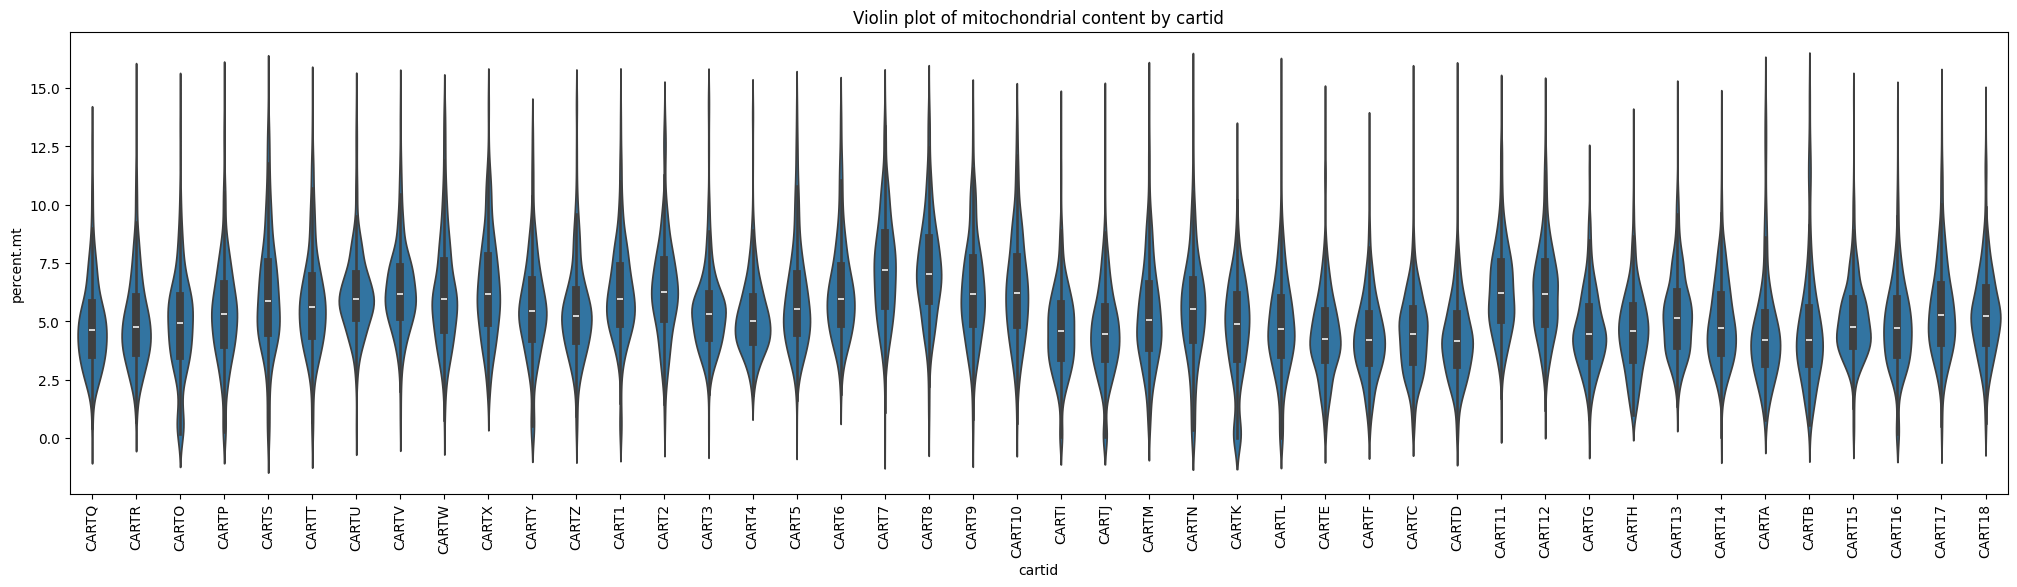

In [4]:
### visualizing the mt content across different carT
f, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.violinplot(x='cartid', y='percent.mt', data=df, ax=ax)
ax.set_title("Violin plot of mitochondrial content by cartid")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

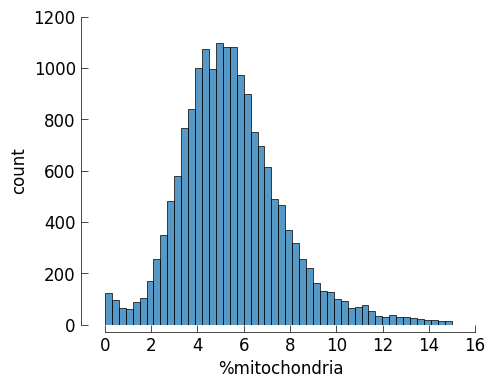

In [5]:
f,ax=plt.subplots(1,1,figsize=(5,4))
var = sns.histplot(df['percent.mt'], bins=50, ax=ax)

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left': 5, 'bottom':5}, 
                            smart_bounds=True,   
                            xticks=[0,2,4,6,8,10,12,14,16],
                            yticks=[0,200,400,600,800,1000,1200],
                            linewidth=0.5)
ax.set_xlabel('%mitochondria')
ax.set_ylabel('count')
# plt.colorbar(var, label= 'percent.mt')
mpl_functions.set_fontsize(f, 12)

In [6]:
## Lets remove the higher mitochondrial content cells and also the skenwness observed in this dataset

# df = df[df['nFeature_RNA'] > 100]  # Cells with at least 200 genes detected
df = df[df['percent.mt'] < 8]  # Less than 5% mitochondrial genes -> because more mitcondrial content shows stressed or dieing cell - chose 8 to avoid skewness in the data
df.reset_index(inplace=True, drop=True)

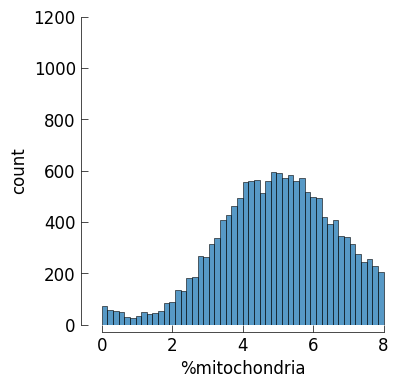

In [9]:
f,ax=plt.subplots(1,1,figsize=(4,4))
var = sns.histplot(df['percent.mt'], bins=50, ax=ax)

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left': 5, 'bottom':5}, 
                            smart_bounds=True,   
                            xticks=[0,2,4,6,8,],
                            yticks=[0,200,400,600,800,1000,1200],
                            linewidth=0.5)
ax.set_xlabel('%mitochondria')
ax.set_ylabel('count')
# plt.colorbar(var, label= 'percent.mt')
mpl_functions.set_fontsize(f, 12)

#### Normalization for the dataset

In [10]:
df.iloc[:, 1:-12]=df.iloc[:, 1:-12].div(df['nCount_RNA'], axis=0) * 1e4
df_convert = df.iloc[:, 1:-12].astype(float)
remaining_columns = pd.concat([df.iloc[:, :1], df.iloc[:, -12:]], axis=1)

# Concatenate the unconverted columns with df_converted
final_df = pd.concat([remaining_columns, df_convert], axis=1)
final_df.iloc[:, 13:] =final_df.iloc[:, 13:].apply(np.log1p)

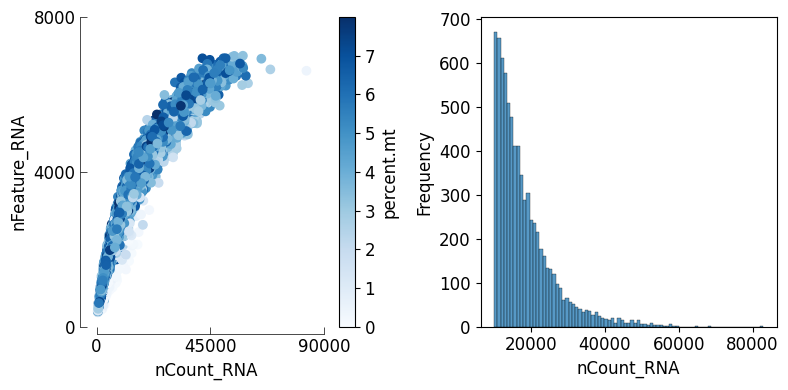

In [21]:
### visualization for outliers and the range of rna coutns
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
var = ax1.scatter(final_df.nCount_RNA, final_df.nFeature_RNA, c=final_df['percent.mt'], cmap='Blues')
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 5, 'bottom': 5}, 
                            smart_bounds=True,   
                            xticks=[0, 45000, 90000],
                            yticks=[0, 4000, 8000],
                            linewidth=0.5)
ax1.set_xlabel('nCount_RNA')
ax1.set_ylabel('nFeature_RNA')
plt.colorbar(var, ax=ax1, label='percent.mt')
sns.histplot(final_df.nCount_RNA[final_df.nCount_RNA > 10000], ax=ax2)

ax2.set_xlabel('nCount_RNA')
ax2.set_ylabel('Frequency')
mpl_functions.set_fontsize(f, 12)

f.tight_layout()

In [22]:
### using scanpy for faster processing

adata = sc.AnnData(final_df.iloc[:, 13:])  # Gene columns are in these indices
metadata_columns = final_df.iloc[:, :13] 

/home/gorilla/An/arunavanag/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


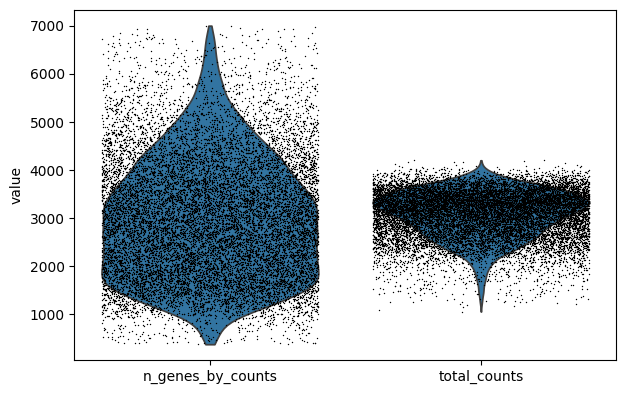

In [23]:
### looking at the kde of the data distribution
sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.4)

Highly variable gene selection (as shown in the plots below), the index of dispersion is used to normalize gene expression variability across different genes. By dividing the variance of gene expression by its mean, we can account for the fact that genes with higher average expression levels will naturally have higher variance. This normalization allows you to compare genes with low and high expression on the same scale.

Left plot: The dispersion (variance/mean) of genes is shown after normalization. The highly variable genes (black dots) are identified regardless of their mean expression levels.

Right plot: The raw dispersion without normalization. Here, the variance would be heavily influenced by the mean expression, which is why normalization is crucial for selecting truly variable genes.
In gene expression analysis, this normalization helps select highly variable genes irrespective of their baseline expression levels. These highly variable genes are then used in downstream analysis, such as clustering or dimensionality reduction.



 Number of highly variable genes: 2961


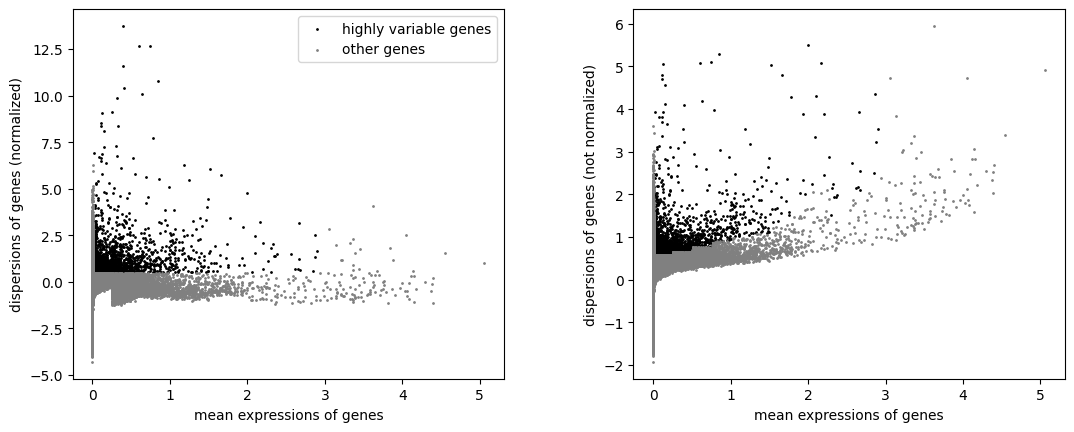

In [24]:
## visualizing highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))
sc.pl.highly_variable_genes(adata)

In [25]:
### will using the HVGs for further analysis
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
highly_variable_genes = adata.var[adata.var['highly_variable']].index
final_df = final_df.loc[:, final_df.columns.isin(highly_variable_genes)]
new_df = pd.concat([metadata_columns, final_df], axis=1)

#### Clustering the gene expression types

2024-10-10 08:35:03.913247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 08:35:03.968711: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 08:35:03.987141: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 08:35:04.097345: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-10 08:35:04.937954: W tensorflow/compiler/tf2

   n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
0               4949                 8.507143   3517.914399   
1               5628                 8.635687   3652.579863   
2               3007                 8.009031   3099.876914   
3               4360                 8.380457   3597.720733   
4               3996                 8.293299   3556.716364   

   log1p_total_counts  pct_counts_in_top_50_genes  \
0            8.165908                    5.428156   
1            8.203463                    5.249740   
2            8.039440                    6.349947   
3            8.188334                    5.354384   
4            8.176874                    5.372376   

   pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
0                    10.012738                    16.991908   
1                     9.688070                    16.410115   
2                    11.765384                    19.774039   
3                     9.903884                    

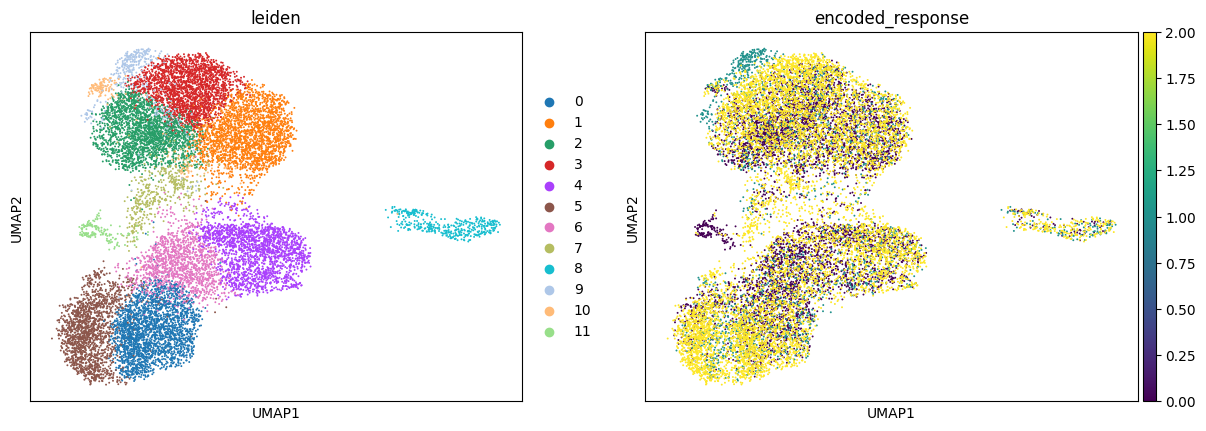

In [26]:
sc.pp.scale(adata)  # Standardize data before PCA
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=40, n_neighbors=30)
sc.tl.umap(adata)

### leiden clustering
sc.tl.leiden(adata, resolution=1.0)
print(adata.obs.head()) 
adata.obs['encoded_response'] = new_df.encoded_response.values
print(adata.obs[['encoded_response']].head())
sc.pl.umap(adata, color=['leiden', 'encoded_response']);

Interestingly partial response forms a separate cluster as in cluster 9 (top left corner) and it will interesting to investigate why?

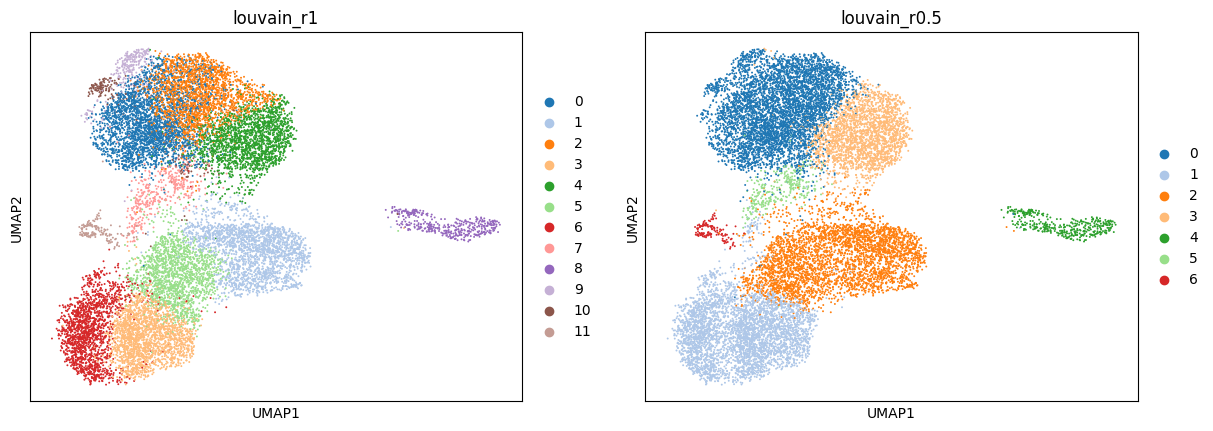

In [27]:
### Louvein clustering
sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5', random_state=10)
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.5'], palette=plt.get_cmap('tab20').colors)

It forms distinct clusters and hence it also indicates the gene_expression might have some relevant information about patient response.
patient_response ~ gene_expression

#### Ranking genes in each cluster helps us pin point the genes that is causing the maximum separation

/home/gorilla/An/arunavanag/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.l

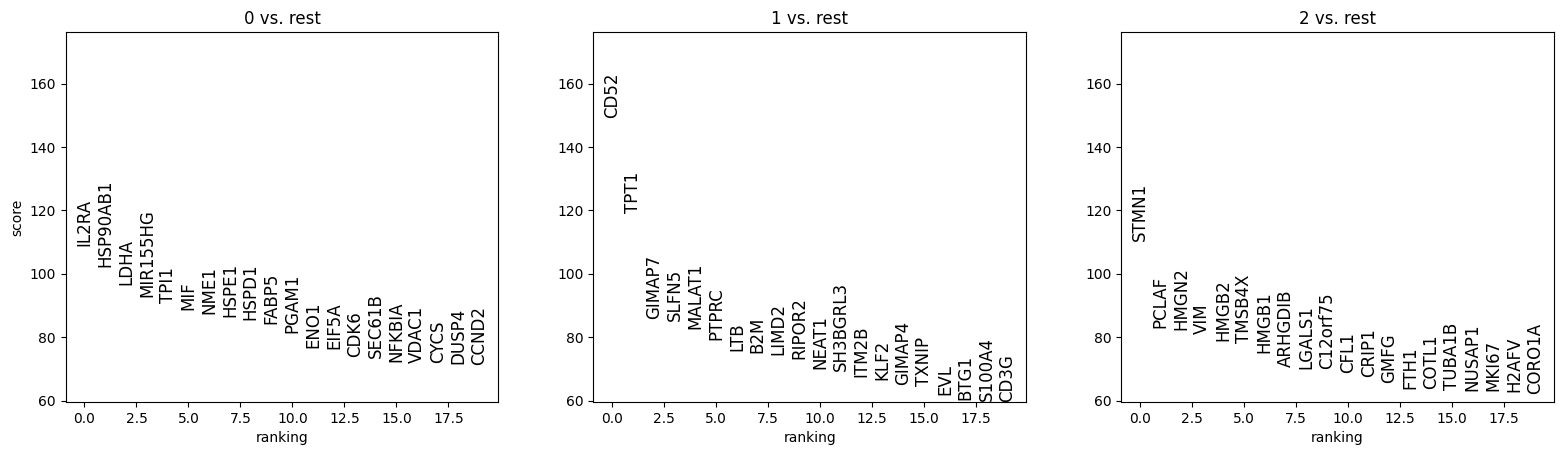

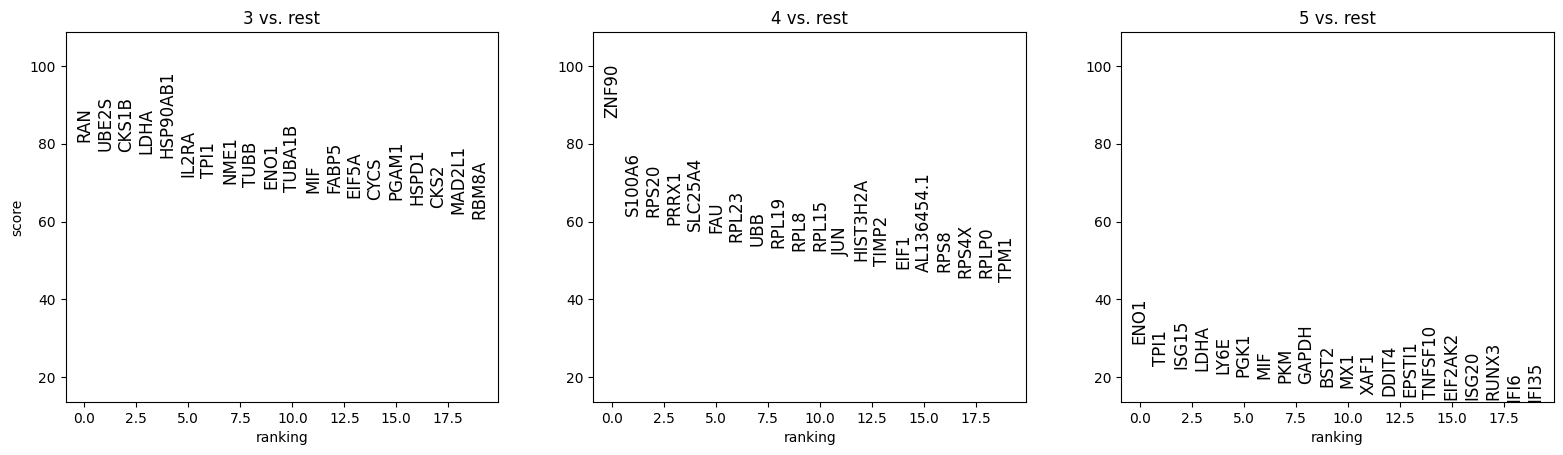

In [29]:
### ranking using louvain
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.5', key_added='rank_genes_r0.5')
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', groups=['0','1','2'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', groups=['3','4','5'], fontsize=12)

/home/gorilla/An/arunavanag/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.l

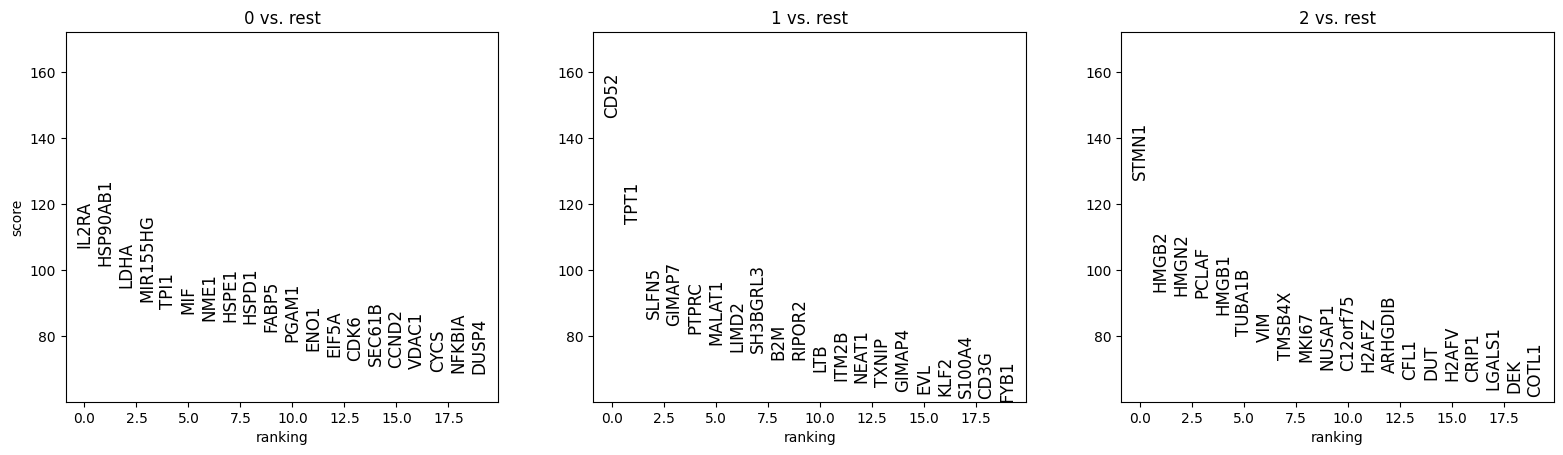

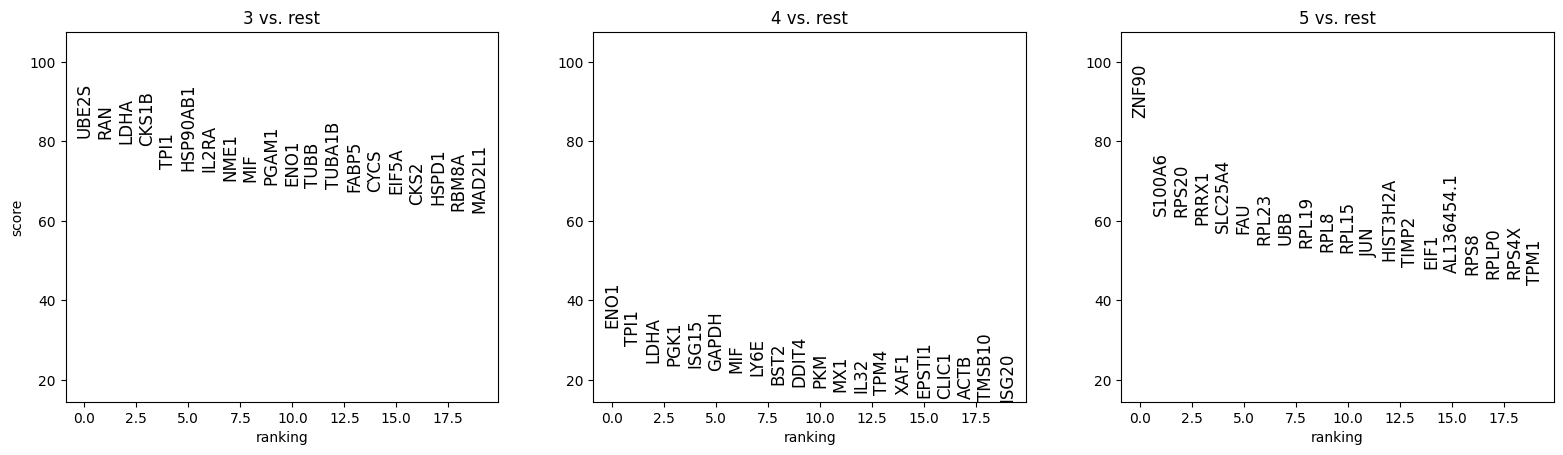

In [30]:
### ranking using leiden

sc.tl.leiden(adata, resolution=0.5, key_added='leiden_r0.5') 
sc.tl.rank_genes_groups(adata, groupby='leiden_r0.5', key_added='rank_genes_leiden_r0.5')
sc.pl.rank_genes_groups(adata, key='rank_genes_leiden_r0.5', groups=['0', '1', '2'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_leiden_r0.5', groups=['3', '4', '5'], fontsize=12)


In [31]:
# Add cluster labels back to the original dataframe
new_df['cluster'] = adata.obs['leiden']
# Group by response and cluster to see distribution
response_cluster_distribution = new_df.groupby(['encoded_response', 'cluster']).size().unstack(fill_value=0)
# print(response_cluster_distribution)

/tmp/ipykernel_171720/2106659703.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  response_cluster_distribution = new_df.groupby(['encoded_response', 'cluster']).size().unstack(fill_value=0)


### Using Random Forest Classifier to model the patient response

In [32]:
X = new_df.iloc[:, 13:]  # Gene expression data
y = new_df['encoded_response']  # Assuming response is encoded numerically

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.6558861578266494
Confusion Matrix:
 [[ 836    0  754]
 [ 184   16  464]
 [ 193    1 2190]]


Text(0, 0.5, 'Importance')

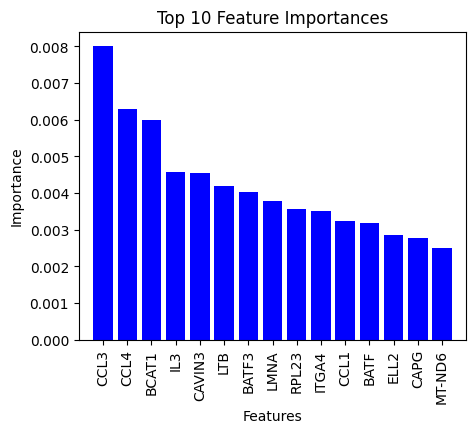

In [35]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
top_indices = indices[:15]
# Create a subplot
f, ax = plt.subplots(1, 1, figsize=(5, 4))

# Plot the feature importances for the top 10 features
ax.bar(range(len(top_indices)), importances[top_indices], align='center', color='blue')
ax.set_xticks(range(len(top_indices)))
ax.set_xticklabels(X.columns[top_indices], rotation=90)
ax.set_xlim([-1, len(top_indices)])
ax.set_title('Top 10 Feature Importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importance')

Given we had distinct clusters it will be interesting to see if we make a linear statsmodel with patient response and the RF filtered important gene expression and see how much of the variance is explained by the the genes

In [36]:
import sys
sys.setrecursionlimit(5000)

import re

# Filter out columns with invalid characters (anything that's not a valid variable name)
filtered_columns = [col for col in X.columns[indices[:2500]] if re.match(r'^[a-zA-Z_][a-zA-Z0-9_]*$', col)]

formula = "encoded_response ~ " + " + ".join(filtered_columns)
results = smf.ols(formula=formula, data=new_df).fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:       encoded_response   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     7.169
Date:                Thu, 10 Oct 2024   Prob (F-statistic):               0.00
Time:                        08:49:23   Log-Likelihood:                -14493.
No. Observations:               15457   AIC:                         3.336e+04
Df Residuals:                   13268   BIC:                         5.010e+04
Df Model:                        2188                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7537      0.086      8.720      0.0

In [37]:
### lets also test how generalizable is this model using cross model
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5)  # 5-fold cross-validation
print("Cross-validated scores:", scores)
print("Average score:", np.mean(scores))

Cross-validated scores: [0.54786546 0.63583441 0.58524749 0.60174701 0.59398253]
Average score: 0.592935380144249


### Locating the CAR T IDs thats driving the response

In [38]:
df = pd.read_hdf('../merged.h5')
df.rename(columns={'orig.ident': 'cartid'}, inplace=True)
encoder = LabelEncoder()
# df['encoded_response']= encoder.fit_transform(df['response'])
response_mapping = {
    'notresponding': 0,
    'partialresponse': 1,
    'completeresponse': 2
}
df['encoded_response'] = df['response'].map(response_mapping)

df = df[df['percent.mt'] < 8]  # Less than 5% mitochondrial genes -> because more mitcondrial content shows stressed or dieing cell - chose 8 to avoid skewness in the data
df.reset_index(inplace=True, drop=True)

df_convert = df.iloc[:, 1:-12].astype(float)
remaining_columns = pd.concat([df.iloc[:, :1], df.iloc[:, -12:]], axis=1)

# Concatenate the unconverted columns with df_converted
final_df = pd.concat([remaining_columns, df_convert], axis=1)

In [39]:
adata1 = sc.AnnData(final_df.iloc[:, 13:]) # Adjust as necessary for gene columns

sc.pp.normalize_total(adata1, target_sum=1e4)
sc.pp.log1p(adata1)

adata1.obs['cart_id'] = final_df['cartid']
adata1.obs['response'] = final_df['encoded_response'].astype('category')  # Ensure 'response' is categorical

/home/gorilla/An/arunavanag/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [40]:
final_df.reset_index(drop=True, inplace=True)
adata1.obs.reset_index(drop=True, inplace=True)

# Now assign the column
adata1.obs['cart_id'] = final_df['cartid']
adata1.obs['response'] = final_df['encoded_response'].astype('category')  # Ensure 'response' is categorical
adata1.obs

,cart_id,response
0,CARTQ,0
1,CARTQ,0
2,CARTQ,0
3,CARTQ,0
4,CARTQ,0
...,...,...
15452,CART17,1
15453,CART17,1
15454,CART18,1
15455,CART18,1


/tmp/ipykernel_171720/4248041910.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata1.obs.groupby(['cart_id', 'response']).size().reset_index(name='counts')
/tmp/ipykernel_171720/4248041910.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  response_summary = grouped.pivot_table(index='cart_id', columns='response', values='counts', fill_value=0)


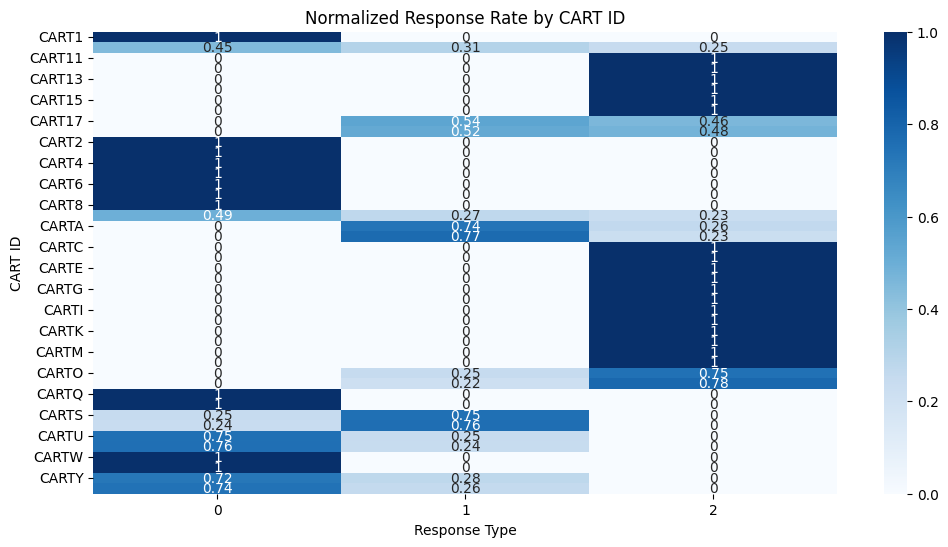

In [41]:
grouped = adata1.obs.groupby(['cart_id', 'response']).size().reset_index(name='counts')

# Now pivot this data to create a response summary similar to what you intended
response_summary = grouped.pivot_table(index='cart_id', columns='response', values='counts', fill_value=0)

# Normalize the counts to get proportions
response_summary = response_summary.div(response_summary.sum(axis=1), axis=0)


plt.figure(figsize=(12, 6))
sns.heatmap(response_summary, annot=True, cmap='Blues')
plt.title('Normalized Response Rate by CART ID')
plt.ylabel('CART ID')
plt.xlabel('Response Type')
plt.show()